In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 

# disable chained assignments
pd.options.mode.chained_assignment = None 

# Data Sources 

For the source of data, lets use the "Weekly Counts of Deaths by State and Select Causes" data from the CDC.

2019-2020: [https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6]

2014-2018: [https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr]

Download these two datasets as CSVs and name them ~/Documents/death_2020.csv and ~/Documents/death_2018.csv 


In order to reduce ambiguity, lets ONLY use the "All Cause" column from this dataset, which tracks deaths per
 week from all causes, so we don't have to worry about if the underlying cause of death was attributed correctly
 or not.  Let's just see if we can compare total death rates in 2020 to the historical averages of 2014-2019 for the same periods.
 
Also, fun fact, the dataset contains deaths by jurisdiction for each state, plus summary rows at the end of the dataset for the entire US.  So don't just sum up all the data by year/week or you'll double count.  Google says 2.8 million peopled died in 2018 so there's a quick sanity checker to ensure we're not too far off.





In [2]:
#Read the 2019-2020 file
df2020all = pd.read_csv('death_2020.csv'); 
df2020all.head()

#Drop all columns except Juristiction, Year, Week, and All Cause
df2020=df2020all.iloc[:, [0, 1, 2, 4]] 
#Fix the labels to be easier to use
print(df2020[:5])
print(df2020[-5:])

  Jurisdiction of Occurrence  MMWR Year  MMWR Week  All Cause
0                    Alabama       2019          1     1077.0
1                    Alabama       2019          2     1090.0
2                    Alabama       2019          3     1114.0
3                    Alabama       2019          4     1063.0
4                    Alabama       2019          5     1095.0
     Jurisdiction of Occurrence  MMWR Year  MMWR Week  All Cause
5286              United States       2020         42    56233.0
5287              United States       2020         43    56674.0
5288              United States       2020         44    55477.0
5289              United States       2020         45    53367.0
5290              United States       2020         46    42566.0


In [3]:
#Read the 2014-2018 file
df2018all = pd.read_csv('death_2018.csv'); 
df2018all.head()

#Drop all columns except Juristiction, Year, Week, and All Cause
df2018=df2018all.iloc[:, [0, 1, 2, 4]] 
print(df2018[:5])
print(df2018[-5:])


  Jurisdiction of Occurrence  MMWR Year  MMWR Week  All  Cause
0                    Alabama       2014          1         355
1                    Alabama       2014          2         872
2                    Alabama       2014          3        1044
3                    Alabama       2014          4        1022
4                    Alabama       2014          5        1040
      Jurisdiction of Occurrence  MMWR Year  MMWR Week  All  Cause
14089              United States       2018         48       55210
14090              United States       2018         49       56095
14091              United States       2018         50       56530
14092              United States       2018         51       56689
14093              United States       2018         52       56163


# Data Cleanup

- One annoying problem is that the "All Cause" column is "All Cause" in one dataset, and "All  Cause" (two spaces) in the other.
- Also, the dataset contains rows for state-level data plus a US-level summary.  Keep only the US level summary rows.
- The first and last points in the dataset (for just US-level) are outliers and should be removed.


In [4]:
#In order to be able to merge them cleanly, lets set the columns to a more helpful set of consitent names.
df2020.columns=['Jurisdiction','Year','Week', 'Deaths']
df2018.columns=['Jurisdiction','Year','Week', 'Deaths']

#merge the dataframes together
dfAllRaw = pd.concat([df2018,df2020])
# More cleanup - We don't need the data broken out by each state, there's a summary row for ALL states
#  called just 'United States'.  Select just those rows.
dfUsRaw = dfAllRaw[dfAllRaw['Jurisdiction'] == 'United States'] 

#The first and last records in the final dataset are suspiciously low, and look outlier-y.  Lets remove them
dfUs = dfUsRaw.iloc[1:].iloc[:-1]

#Check our work
print(dfUs[:5])
print(dfUs[-5:])

        Jurisdiction  Year  Week   Deaths
13834  United States  2014     2  55715.0
13835  United States  2014     3  54681.0
13836  United States  2014     4  54175.0
13837  United States  2014     5  54049.0
13838  United States  2014     6  53492.0
       Jurisdiction  Year  Week   Deaths
5285  United States  2020    41  57997.0
5286  United States  2020    42  56233.0
5287  United States  2020    43  56674.0
5288  United States  2020    44  55477.0
5289  United States  2020    45  53367.0


In [5]:
#Add a helpful column that's the year and week joined together with short weeks like 4 padded to '04'
yr = dfUs['Year'].astype(str)+'-'+dfUs['Week'].astype(str).str.pad(2,fillchar='0')
dfUs['YYYY-WW'] = yr
print(dfUs[:5])
print(dfUs[-5:])



        Jurisdiction  Year  Week   Deaths  YYYY-WW
13834  United States  2014     2  55715.0  2014-02
13835  United States  2014     3  54681.0  2014-03
13836  United States  2014     4  54175.0  2014-04
13837  United States  2014     5  54049.0  2014-05
13838  United States  2014     6  53492.0  2014-06
       Jurisdiction  Year  Week   Deaths  YYYY-WW
5285  United States  2020    41  57997.0  2020-41
5286  United States  2020    42  56233.0  2020-42
5287  United States  2020    43  56674.0  2020-43
5288  United States  2020    44  55477.0  2020-44
5289  United States  2020    45  53367.0  2020-45


In [6]:
#Just a sanity check - should be about 2.8 million 
totalDeathsIn2018 = dfUs.loc[dfUs['Year']==2018]['Deaths'].sum();
print(totalDeathsIn2018)


2839076.0


# What's a "normal" number of people that die by week?

Lets take all the data EXCEPT for 2020, and figure out what the average number of people that die for each week
by averaging the mortality by week for 2014-2019:

In [7]:
#Lets figure out what the *normal* number of deaths per week is.  
#Create a dataframe of everything *except* 2020's deaths:
dfOld = dfUs[dfUs['Year'] < 2020]
#dfOld.tail()

#Lets try a simple mean/median by week as two simple predictors
avgDeathsDf = dfOld.groupby('Week').agg({'Deaths':[np.median,np.mean]}).reset_index()
print(avgDeathsDf[:5])
print(avgDeathsDf[-5:])
vals = avgDeathsDf.values;
#print(vals)
dictMedian = {a : b for a,b,c in vals}
dictMean = {a : c for a,b,c in vals}
print(dictMedian)


#And, because machine learning is the new hotness, lets try using XGBoost to build a 
# regression model for a more sophisticated predictor:
#Big thanks for this guy: https://www.geeksforgeeks.org/xgboost-for-regression/
xgBoostDfXold = dfOld[['Year', 'Week']].copy()
xgBoostDfYold = dfOld['Deaths'].copy()
train_X, test_X, train_y, test_y = train_test_split(xgBoostDfXold, xgBoostDfYold, test_size = 0.3, random_state=42) 
 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123) 
xgb_r.fit(train_X, train_y) 

# Use the model to predict our test data
xgbPredTest = xgb_r.predict(test_X) 

#Now use it to predict ALL the values in the dataset
xgBoostDfXall = dfUs[['Year', 'Week']].copy()
xgbPredAll = xgb_r.predict(xgBoostDfXall) 



  Week   Deaths              
         median          mean
0    1  59898.0  60498.800000
1    2  59824.5  59992.500000
2    3  58548.5  58554.666667
3    4  57710.0  57739.666667
4    5  57838.5  57398.166667
   Week   Deaths              
          median          mean
48   49  55501.0  55165.500000
49   50  56320.0  55595.333333
50   51  56754.0  56398.333333
51   52  56967.0  57098.166667
52   53  59481.0  59481.000000
{1.0: 59898.0, 2.0: 59824.5, 3.0: 58548.5, 4.0: 57710.0, 5.0: 57838.5, 6.0: 57587.0, 7.0: 57294.0, 8.0: 56872.5, 9.0: 56419.0, 10.0: 56729.0, 11.0: 55508.5, 12.0: 55352.5, 13.0: 54515.5, 14.0: 54727.0, 15.0: 54286.0, 16.0: 53217.5, 17.0: 52494.5, 18.0: 52251.0, 19.0: 51600.0, 20.0: 50656.5, 21.0: 50823.5, 22.0: 50492.5, 23.0: 50778.0, 24.0: 50467.5, 25.0: 50479.5, 26.0: 50302.5, 27.0: 50443.0, 28.0: 49934.0, 29.0: 49811.0, 30.0: 49648.0, 31.0: 49936.0, 32.0: 50100.5, 33.0: 50109.0, 34.0: 49638.0, 35.0: 50218.0, 36.0: 50321.5, 37.0: 50626.5, 38.0: 50674.0, 39.0: 50735

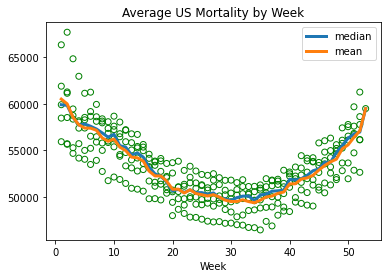

In [8]:
#Plot overall mortality by week of year.  
avgDeathsDf.plot.line(x='Week', y='Deaths',title='Average US Mortality by Week',linewidth=3)
plt.scatter(x=dfOld['Week'],y=dfOld['Deaths'],facecolors='none', edgecolors='g')
#Wow the ends of the year are dangerous times to be alive

In [11]:
#Now put the expected # of deaths by week back into the dataframe using a map of the dict we created earlier
dfUs['ExpectedDeathsMedian'] = dfUs["Week"].map(dictMedian)
dfUs['ExpectedDeathsMean'] = dfUs["Week"].map(dictMean)
dfUs['ExpectedDeathsXgb'] = xgbPredAll
dfUs.head()


#What's the R2 value for our predicted vs actual for 2014-2019?
rmseMed = np.sqrt(MSE(dfUs[dfUs['Year'] < 2020]['Deaths'], dfUs[dfUs['Year'] < 2020]['ExpectedDeathsMedian'])) 
rmseMea = np.sqrt(MSE(dfUs[dfUs['Year'] < 2020]['Deaths'], dfUs[dfUs['Year'] < 2020]['ExpectedDeathsMean'])) 
rmseXgb = np.sqrt(MSE(dfUs[dfUs['Year'] < 2020]['Deaths'], dfUs[dfUs['Year'] < 2020]['ExpectedDeathsXgb'])) 
print("RMSE Median:",rmseMed,"RMSE Mean:",rmseMea,"RMSE XGBoost:",rmseXgb)

#Of the 3 techniques, Mean has the lowest RMSE

RMSE Median: 1962.5359228298055 RMSE Mean: 1932.2438512364388 RMSE XGBoost: 2127.6515559635823


# Results

Plot the actual number of deaths by week versus the "expected" number of deaths for that week from our previously calculated averages.

Things to look for:
 - Do deaths & expected deaths track well in our historical data?
 - Sections where the blue line is above the orange line means more people are dying in that week than the historical averages would suggest

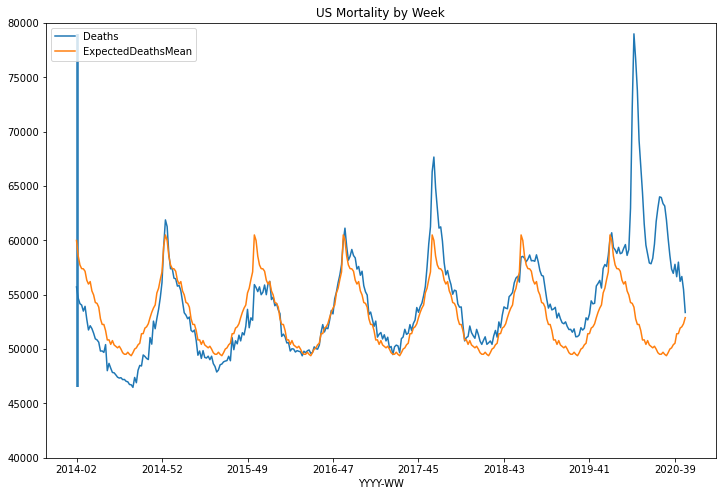

In [12]:
y_min = dfUs.Deaths.min()
y_max = dfUs.Deaths.max()

dfUs.plot(title='US Mortality by Week',x='YYYY-WW',y=['Deaths','ExpectedDeathsMean'],figsize=(12,8),ylim=(40000,80000))
#Why can't i draw vertical year lines?
#plt.vlines(x=['2015-01','2016-01'],ymin=y_min, ymax=y_max)

# Intepreting the results

- There's a pretty clear deviation from 'normal' staring in early 2020 and remaining strong through the rest of the year.  Independent of *why* its pretty obvious that a lot more people are dying now than compared to the trend suggested by historical data.



# Suggestions for future work:
 - ~~Try using a simple ML model like XGBoost for a more sophisticated expected death rate predictor~~ (turns out mean was still a better predictor!)
 - Correct historical averages for US population by year
 - Why can't i get nice x-axis tickmarks showing the start of each year?  Darn you matplotlib!